# Learning to Play Acrobot with Advantage Actor-Critic
This notebook gives an example of an A2C model which learns to play [Acrobot](https://gym.openai.com/envs/Acrobot-v1/). The Acrobot system includes two joints and two links, where the joint between the two links is actuated. Initially, the links are hanging downwards, and the goal is to swing the end of the lower link up to a given height.

## The Environment
We'll use Open AI's [Gym](https://gym.openai.com/) library, and Tensorflow to implement the algorithm. The action is either applying +1, 0 or -1 torque on the joint between the two pendulum links - so there are 3 possible actions. The state consists of the _sin_ and _cos_ of the two rotational joint angles and the joint angular velocities: `[cos(theta1) sin(theta1) cos(theta2) sin(theta2) thetaDot1 thetaDot2]`. More information is available on the environment's [GitHub page](https://github.com/openai/gym/blob/master/gym/envs/classic_control/acrobot.py).

In [1]:
import gym
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

Setting up the environment:

In [2]:
env = gym.make('Acrobot-v1')
state_size = env.observation_space.shape[0]
num_of_actions = env.action_space.n

The environment is designed to give a reward of `-1` for every step, and a reward of `0` when the game ends. As we'd like to promote the agent to reach its end-goal faster, we'll give it a high reward if it succeeds in tis task:

In [3]:
end_game_reward = 100

## The Critic
We'll use a simple neural network with a MSE cost to implement the critic. It's quite similar to a Deep Q-Network, only here it outputs a single value per state - the state value $V(s)$.

An important technical detail here is the optimizer we use: Adam. The learning process will be very noisy, and using a overly naive optimizer such as a simple Gradient Descent Optimizer won't do, and is quite likely to be unable to learn (try it - replace the `AdamOptimizer` with a `GradientDescentOptimizer` and run the notebook).

In [4]:
class VNetwork:
    def __init__(self, hidden_layers_size, gamma, learning_rate, input_size):
        self.v_target = tf.placeholder(shape=None, dtype=tf.float32, name='dvn_v_target')
        self.r = tf.placeholder(shape=None,dtype=tf.float32, name='dvn_r')
        self.states = tf.placeholder(shape=(None, input_size), dtype=tf.float32, name='dvn_states')
        
        _layer = self.states
        for l in hidden_layers_size:
            _layer = tf.layers.dense(inputs=_layer, units=l, activation=tf.nn.relu,
                                     kernel_initializer=tf.contrib.layers.xavier_initializer())
        self.predictions = tf.layers.dense(inputs=_layer, units=1, activation=None,  # Linear activation
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        self.labels = self.r + gamma * self.v_target
        self.cost = tf.reduce_mean(tf.losses.mean_squared_error(labels=self.labels, predictions=self.predictions))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)

## The Actor
The actor is simply an Policy Gradient model, with a simple change in the inputs: it receives the current action's Advantage instead of the future accumulated reward.

In [5]:
class PolicyGradient:
    def __init__(self, hidden_layers_size, gamma, learning_rate, input_size, num_of_actions):
        self.states = tf.placeholder(shape=(None, input_size), dtype=tf.float32, name='pg_states')
        self.r = tf.placeholder(shape=None, dtype=tf.float32, name='pg_r') 
        self.v = tf.placeholder(shape=None, dtype=tf.float32, name='pg_v') 
        self.v_target = tf.placeholder(shape=None, dtype=tf.float32, name='pg_v_target') 
        self.actions = tf.placeholder(shape=None, dtype=tf.int32, name='pg_actions')
                
        _layer = self.states
        for l in hidden_layers_size:
            _layer = tf.layers.dense(inputs=_layer, units=l, activation=tf.nn.relu,
                                     kernel_initializer=tf.contrib.layers.xavier_initializer())
        self.last_layer = tf.layers.dense(inputs=_layer, units=num_of_actions, activation=None, # Linear activation
                                          kernel_initializer=tf.contrib.layers.xavier_initializer())
        self.action_prob = tf.nn.softmax(self.last_layer)
        self.a = self.r + gamma * self.v_target - self.v
        self.log_policy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.last_layer, labels=self.actions)
        self.cost = tf.reduce_mean(self.a * self.log_policy) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)

## A2C
All that's left is simply connect these two toghether, and some functionality: 

In [6]:
class A2C:
    def __init__(self, input_size, num_of_actions, actor_hidden_layers_size, critic_hidden_layers_size, 
                 actor_gamma, critic_gamma, actor_learning_rate, critic_learning_rate):
        self.critic = VNetwork(critic_hidden_layers_size, critic_gamma, critic_learning_rate, input_size)
        self.actor = PolicyGradient(actor_hidden_layers_size, actor_gamma, actor_learning_rate, input_size,
                                    num_of_actions)
        self.memory = []
        self.num_of_actions = num_of_actions
    
    def _extract_from_batch(self, batch, key):
        return np.array(list(map(lambda x: x[key], batch)))
    
    def _update_terminal_states(self, v_target, terminals):
        for i in range(len(terminals)):
            if terminals[i]:
                v_target[i] = 0.0 
        return v_target
    
    def remember(self, **kwargs):
        self.memory.append(kwargs)

    def actions_prob(self, session, state): 
        return session.run(self.actor.action_prob, feed_dict={self.actor.states: np.expand_dims(state, axis=0)}).flatten()
        
    def act(self, session, state, greedy=False):
        actions_prob = self.actions_prob(session, state)
        if greedy:
            action = np.argmax(actions_prob)
        else:
            action = np.random.choice(self.num_of_actions, p=actions_prob)
        return action
    
    def learn(self, session):
        batch = shuffle(self.memory)
        next_states = self._extract_from_batch(batch, 'next_state')
        states = self._extract_from_batch(batch, 'state')
        rewards = self._extract_from_batch(batch, 'reward')
        actions = self._extract_from_batch(batch, 'action')
        terminals = self._extract_from_batch(batch, 'game_over')
        
        v = session.run(self.critic.predictions, feed_dict={self.critic.states: states}) 
        v_t = session.run(self.critic.predictions, feed_dict={self.critic.states: next_states})
        v_t = self._update_terminal_states(v_t, terminals=terminals)
        
        actor_cost, _, critic_cost, _ = session.run([self.actor.cost, self.actor.optimizer, 
                                                     self.critic.cost, self.critic.optimizer], 
                                                    feed_dict={self.actor.states: states,
                                                               self.actor.r: r,
                                                               self.actor.v: v,
                                                               self.actor.v_target: v_t,
                                                               self.actor.actions: actions,
                                                               self.critic.v_target: v_t, 
                                                               self.critic.r: rewards,
                                                               self.critic.states: states})
        if np.isnan(actor_cost) or np.isnan(critic_cost): raise Exception('NaN cost!')
        self.memory = []
        return actor_cost, critic_cost

Let's set-up our hyper-parameters. We'll use two shallow networks (only a single hidden layer) for the Actor and a little deeper network with two hidden layers for the Critic:

In [7]:
actor_hidden_layers = [24]
critic_hidden_layers = [24,24]
learning_rate = 0.001
gamma = 0.99

Let's set-up our agent:

In [8]:
sess = tf.Session()
ac = A2C(input_size=state_size, num_of_actions=num_of_actions, 
         actor_hidden_layers_size=actor_hidden_layers, critic_hidden_layers_size=critic_hidden_layers, 
         actor_gamma=gamma, critic_gamma=gamma, 
         actor_learning_rate=learning_rate, critic_learning_rate=learning_rate)

In [9]:
game_df = pd.DataFrame(columns=['game','steps','actor_cost','critic_cost'])
sess.run(tf.global_variables_initializer())

Time to train! The Actor-Critic mechanism allows us to train at any step, without waiting for the episode to end. Let's train the Agent after every action it takes.

In [10]:
def print_stuff(s, every=50):
    if game % every == 0 or game == 1:
        print(s)

In [11]:
games = 1000

for g in range(games):
    game = g + 1
    game_over = False
    next_state = env.reset()
    steps = 0
    while not game_over:
        steps += 1
        state = np.copy(next_state)
        action = ac.act(sess, state)
        next_state, r, game_over, _ = env.step(action)
        if game_over and steps < env._max_episode_steps: r = end_game_reward   
        ac.remember(state=state, action=action, reward=r, next_state=next_state, game_over=game_over)
        actor_cost, critic_cost = ac.learn(sess)
    print_stuff('Game {g} ended after {s} steps | Actor cost: {a:.2e}, Critic cost: {c:.2e}'.format(g=game, s=steps, a=actor_cost, c=critic_cost))
    game_df = game_df.append({'game':game, 'steps':steps, 'actor_cost':actor_cost, 'critic_cost':critic_cost},
                             ignore_index=True)

Game 1 ended after 500 steps | Actor cost: 6.04e+01, Critic cost: 3.30e+03
Game 50 ended after 87 steps | Actor cost: 1.27e+02, Critic cost: 8.05e+03
Game 100 ended after 79 steps | Actor cost: 7.30e-01, Critic cost: 7.46e+03
Game 150 ended after 89 steps | Actor cost: 2.28e-01, Critic cost: 3.03e+03
Game 200 ended after 91 steps | Actor cost: 4.05e-06, Critic cost: 1.16e+03
Game 250 ended after 90 steps | Actor cost: 0.00e+00, Critic cost: 7.40e+02
Game 300 ended after 92 steps | Actor cost: 0.00e+00, Critic cost: 6.63e+02
Game 350 ended after 72 steps | Actor cost: 0.00e+00, Critic cost: 1.02e+03
Game 400 ended after 75 steps | Actor cost: 0.00e+00, Critic cost: 3.47e+03
Game 450 ended after 86 steps | Actor cost: 0.00e+00, Critic cost: 8.63e+02
Game 500 ended after 81 steps | Actor cost: 0.00e+00, Critic cost: 1.13e+02
Game 550 ended after 78 steps | Actor cost: 0.00e+00, Critic cost: 1.93e+02
Game 600 ended after 73 steps | Actor cost: 0.00e+00, Critic cost: 3.36e+02
Game 650 ended

Let's see how well the Agent learned:

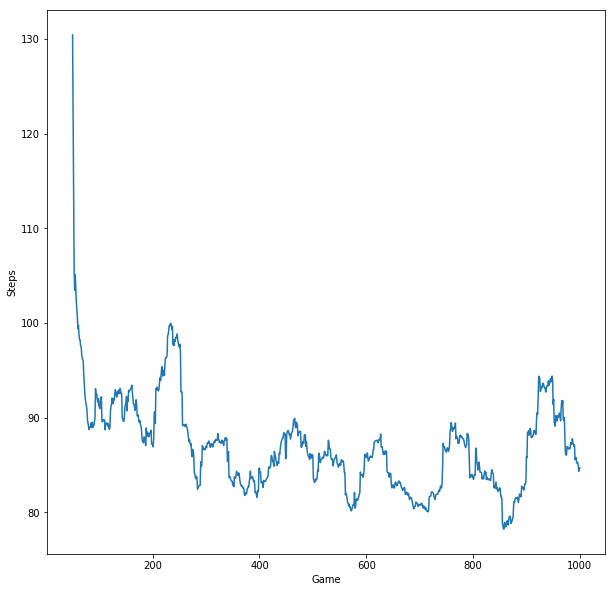

In [12]:
game_df['steps_moving_average'] = game_df['steps'].rolling(window=50).mean()
ax = game_df.plot('game','steps_moving_average', figsize=(10,10), legend=False)
ax.set_xlabel('Game')
ax.set_ylabel('Steps')
plt.show()

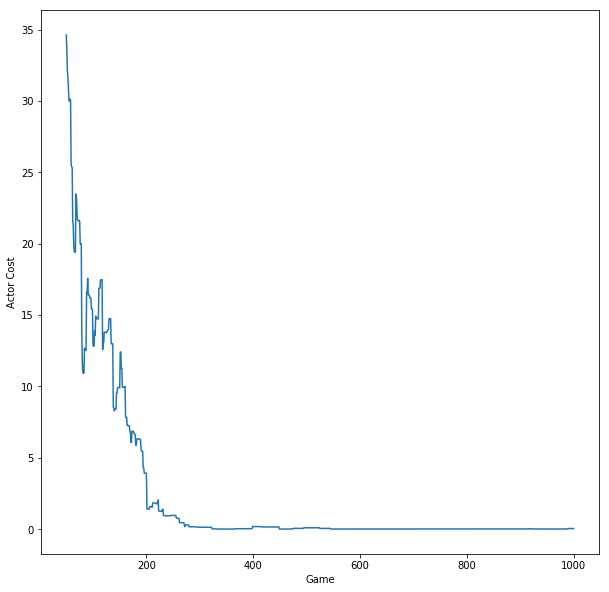

In [13]:
game_df['actor_cost_moving_average'] = game_df['actor_cost'].rolling(window=50).mean()
ax = game_df.plot('game','actor_cost_moving_average', figsize=(10,10), legend=False)
ax.set_xlabel('Game')
ax.set_ylabel('Actor Cost')
plt.show()

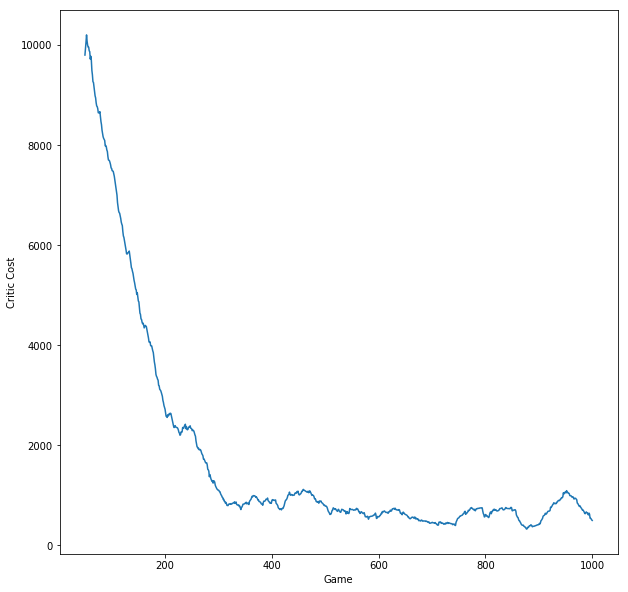

In [14]:
game_df['critic_cost_moving_average'] = game_df['critic_cost'].rolling(window=50).mean()
ax = game_df.plot('game','critic_cost_moving_average', figsize=(10,10), legend=False)
ax.set_xlabel('Game')
ax.set_ylabel('Critic Cost')
plt.show()

## Exploitaion
Let's see how well did the Agent learned - now we won't sample an action, but always select the one with the higher probability:

In [15]:
next_state = env.reset()
env.render()
game_over = False
steps = 0
while not game_over:
    steps += 1
    state = np.copy(next_state)
    action = ac.act(sess, state, greedy=True)
    action_prob = ac.actions_prob(sess, state).tolist()
    next_state, _, game_over, _ = env.step(action)
    env.render()
print('Ended after {} steps'.format(steps))

Ended after 70 steps
